In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Define_Basic_Parameters

In [5]:
# define the year_name for test, here choose these years because they represent
# Landsat8/7/5 respectively
year_name = ['2017_2019','2011_2013', '2008_2010']
percent_value = [0,1,2,3,5,7,10,20,30,50,70,100]
tree_num = [1] + list(range(10,121,10))

##### Classify Sample_with_img_value

In [6]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# fetch the Verified_points_with_value
Sample_with_value = [ee.FeatureCollection(f'{path}/Verified_point_{year}_extract_Landsat_Fourier_Normalized_img')
                    for year in year_name] 

# fetch the Zone_points_with_value
Zone_with_value   = [ee.FeatureCollection(f'{path}/Zone_point_{year}_extract_Landsat_Fourier_Normalized_img')
                    for year in year_name]

# Merge Verified_points with Zone_points
Verified_merge_Zone = [i[0].merge(i[1]) for i in zip(Sample_with_value,Zone_with_value)]

In [16]:
def Step_1_Subset_Zone_sample(Zone_sample,percent):
   
    Zone_sample_select_num = int(Zone_sample.size().getInfo() * percent /100)
    print(f'Zone sample size added is {Zone_sample_select_num}')
    
    # add some randomness so to make the result more reliable
    return Zone_sample.randomColumn('x', 101).limit(Zone_sample_select_num,'x')

def Step_2_Create_Band_Combo(fe):
    
    # use the first element to get all band name
    bands = list(fe.first().getInfo()['properties'].keys())
    
    # get the Landsat_band
    Landsat_re   = re.compile(r'^B\d')
    Landsat_band = list(filter(Landsat_re.match,bands))

    # get the Fourier_band
    Fourier_re   = re.compile(r'^EVI|NDBI|NDVI')
    Fourier_band = list(filter(Fourier_re.match,bands))
    
    # get the Mean_Normalized band
    Mean_re         = re.compile(r'^Mean')
    Mean_Normalized = list(filter(Mean_re.match,bands))
    
    # ________________________Create sample classification instaces_____________________________
    
    # create band_combinations
    band_combination = [Landsat_band,
                        Fourier_band,
                        Landsat_band + Fourier_band,
                        Landsat_band + Mean_Normalized,
                        Fourier_band + Mean_Normalized,
                        Landsat_band + Fourier_band + Mean_Normalized]
    
    # create comno_names
    global combination_name
    combination_name = ['Landsat',
                        'Fourier',
                        'Landsat_Fourier',
                        'Landsat_Mean',
                        'Fourier_Mean',
                        'Landsat_Fourier_Mean']
    
    
    return list(zip(combination_name,band_combination))

def Step_3_Create_Classification_Instance(year,verified_pt,combo,tree_list,percent):
    # Initiate the Combo_dict
    Combo_acc_dict = {}
    
    for tree in tree_list:
            
        combo_name = combo[0]
        combo_band = combo[1]

        # Instatiate the class with a name
        Sample_classification = Classification( year_name    = year,
                                              Input_band     = combo_band,
                                              Verified_point = verified_pt,
                                              Tree_num       = tree)

        # Proceed the classification
        Sample_classification.Stp_2_Classification_on_Samples()
        
        # add accuracy to the dictionary
        Combo_acc_dict.update({(year,combo_name,percent,tree) : Sample_classification.Test_sample_classification})
        
        # print out the process
        print(f'Classification of {year}_{combo_name}_pct_{percent:03}_tree_{tree:04} completed!')
        
    # get the accuracy value
    return Combo_acc_dict
    

In [17]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# instantiate the combo_instance dictionary
Combo_instance = {}

# Create sample_classification instances through [year] --> [Percent] --> [band_combination] --> [Tree]
for year in year_name:
    
    Verified_sample = ee.FeatureCollection(f'{path}/Verified_point_{year}_extract_Landsat_Fourier_Normalized_img')
    Zone_sample     = ee.FeatureCollection(f'{path}/Zone_point_{year}_extract_Landsat_Fourier_Normalized_img')
    
    for pct in percent_value:
        Subset_zone_sample  = Step_1_Subset_Zone_sample(Zone_sample,pct)
        # Merge Verified_points with Zone_points
        Verified_merge_Zone = Subset_zone_sample.merge(Verified_sample)
        Band_combo          = Step_2_Create_Band_Combo(Verified_merge_Zone)
        
        for combo in Band_combo:
            Accuracy_instance = Step_3_Create_Classification_Instance(year,Verified_merge_Zone,combo,tree_num,pct) 
            Combo_instance.update(Accuracy_instance)
        

Zone sample size added is 0
Classification of 2017_2019_Landsat_pct_000_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_000_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_000_tree_0010 complete

Zone sample size added is 164
Classification of 2017_2019_Landsat_pct_002_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_002_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_002_tree_0010 comple

Zone sample size added is 411
Classification of 2017_2019_Landsat_pct_005_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_005_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_005_tree_0010 comple

Zone sample size added is 823
Classification of 2017_2019_Landsat_pct_010_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_010_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_010_tree_0010 comple

Zone sample size added is 2470
Classification of 2017_2019_Landsat_pct_030_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_030_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_030_tree_0010 compl

Zone sample size added is 5763
Classification of 2017_2019_Landsat_pct_070_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_070_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_070_tree_0010 compl

Zone sample size added is 0
Classification of 2011_2013_Landsat_pct_000_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_000_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_000_tree_0010 complete

Zone sample size added is 164
Classification of 2011_2013_Landsat_pct_002_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_002_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_002_tree_0010 comple

Zone sample size added is 411
Classification of 2011_2013_Landsat_pct_005_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_005_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_005_tree_0010 comple

Zone sample size added is 823
Classification of 2011_2013_Landsat_pct_010_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_010_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_010_tree_0010 comple

Zone sample size added is 2470
Classification of 2011_2013_Landsat_pct_030_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_030_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_030_tree_0010 compl

Zone sample size added is 5763
Classification of 2011_2013_Landsat_pct_070_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_070_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_070_tree_0010 compl

Zone sample size added is 0
Classification of 2008_2010_Landsat_pct_000_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_000_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_000_tree_0010 complete

Zone sample size added is 164
Classification of 2008_2010_Landsat_pct_002_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_002_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_002_tree_0010 comple

Zone sample size added is 411
Classification of 2008_2010_Landsat_pct_005_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_005_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_005_tree_0010 comple

Zone sample size added is 823
Classification of 2008_2010_Landsat_pct_010_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_010_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_010_tree_0010 comple

Zone sample size added is 2470
Classification of 2008_2010_Landsat_pct_030_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_030_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_030_tree_0010 compl

Zone sample size added is 5763
Classification of 2008_2010_Landsat_pct_070_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_070_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_070_tree_0010 compl

In [18]:
# innitialize the accuracy dict
Combo_acc = {}

# innitilize operation flag to report the process
Opts_flat  = 0
Opts_tatal = len(year_name) * len(combination_name) * len(percent_value) * len(tree_num)

# unpack the combo_instance through [year] --> [band_combination] --> [Percent] --> [Tree]
for year in year_name:
    for name in combination_name:
        for pct in percent_value:
            for tree in tree_num:

                Opts_flat+=1

                Combo_acc[(year,name,pct,tree)] = Accuracy_assesment(Combo_instance[(year,name,pct,tree)])\
                                              .Stp_1_Calculate_Accuracy()
                # print out the process
                print(f'{year}_{name}_pct_{pct:03}_tree_{tree:03} accuracy computation finished! ==>{Opts_flat:04}/{Opts_tatal}')
            print('_________________')

2017_2019_Landsat_pct_000_tree_001 accuracy computation finished! ==>0001/2808
2017_2019_Landsat_pct_000_tree_010 accuracy computation finished! ==>0002/2808
2017_2019_Landsat_pct_000_tree_020 accuracy computation finished! ==>0003/2808
2017_2019_Landsat_pct_000_tree_030 accuracy computation finished! ==>0004/2808
2017_2019_Landsat_pct_000_tree_040 accuracy computation finished! ==>0005/2808
2017_2019_Landsat_pct_000_tree_050 accuracy computation finished! ==>0006/2808
2017_2019_Landsat_pct_000_tree_060 accuracy computation finished! ==>0007/2808
2017_2019_Landsat_pct_000_tree_070 accuracy computation finished! ==>0008/2808
2017_2019_Landsat_pct_000_tree_080 accuracy computation finished! ==>0009/2808
2017_2019_Landsat_pct_000_tree_090 accuracy computation finished! ==>0010/2808
2017_2019_Landsat_pct_000_tree_100 accuracy computation finished! ==>0011/2808
2017_2019_Landsat_pct_000_tree_110 accuracy computation finished! ==>0012/2808
2017_2019_Landsat_pct_000_tree_120 accuracy computat

2017_2019_Landsat_pct_020_tree_120 accuracy computation finished! ==>0104/2808
_________________


KeyboardInterrupt: 

In [19]:
# convert the accuracy dicionary into a dataframe
Combo_acc_df = pd.DataFrame(Combo_acc).T
Combo_acc_df.index.names = ['Year','Combo','Percent','Tree']

# save the dataframe
Combo_acc_df.to_csv('./Step_2_result/Classification_ACC_with_zone_point.csv')

In [20]:
Combo_acc_df

Overall_ACC  Precisioin_non_built  \
Year      Combo   Percent Tree                                      
2017_2019 Landsat 0       1           86.76                 91.68   
                          10          91.26                 92.54   
                          20          91.46                 92.92   
                          30          91.46                 93.05   
                          40          91.26                 92.97   
...                                     ...                   ...   
                  20      80          90.49                 91.72   
                          90          90.46                 91.80   
                          100         90.52                 91.84   
                          110         90.46                 91.80   
                          120         90.46                 91.80   

                                Precisioin_built  Recall_non_built  \
Year      Combo   Percent Tree                                       
2017_2019 Landsat 0       1                49.72             93.21   
                          10               77.02             97.83   
                          20               76.32             97.60   
                          30               75.55             97.45   
                          40               74.28             97.29   
...                                          ...               ...   
                  20      80               85.98             96.01   
                          90               85.58             95.86   
                          100              85.71             95.89   
                          110              85.58             95.86   
                          120              85.58             95.86   

                                Recall_built  
Year      Combo   Percent Tree                
2017_2019 Landsat 0       1            44.22  
                          10           47.99  
                          20           51.01  
                          30           52.01  
                          40           51.51  
...                                      ...  
                  20      80           73.84  
                          90           74.19  
                          100          74.31  
                          110          74.19  
                          120          74.19  

[104 rows x 5 columns]

In [21]:
Combo_acc_df = pd.read_csv('./Step_2_result/Classification_ACC_with_zone_point.csv')
Combo_acc_df.set_index('Tree')

,Year,Combo,Percent,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
Tree,,,,,,,,
1,2017_2019,Landsat,0,86.76,91.68,49.72,93.21,44.22
10,2017_2019,Landsat,0,91.26,92.54,77.02,97.83,47.99
20,2017_2019,Landsat,0,91.46,92.92,76.32,97.60,51.01
30,2017_2019,Landsat,0,91.46,93.05,75.55,97.45,52.01
40,2017_2019,Landsat,0,91.26,92.97,74.28,97.29,51.51
...,...,...,...,...,...,...,...,...
80,2017_2019,Landsat,20,90.49,91.72,85.98,96.01,73.84
90,2017_2019,Landsat,20,90.46,91.80,85.58,95.86,74.19
100,2017_2019,Landsat,20,90.52,91.84,85.71,95.89,74.31


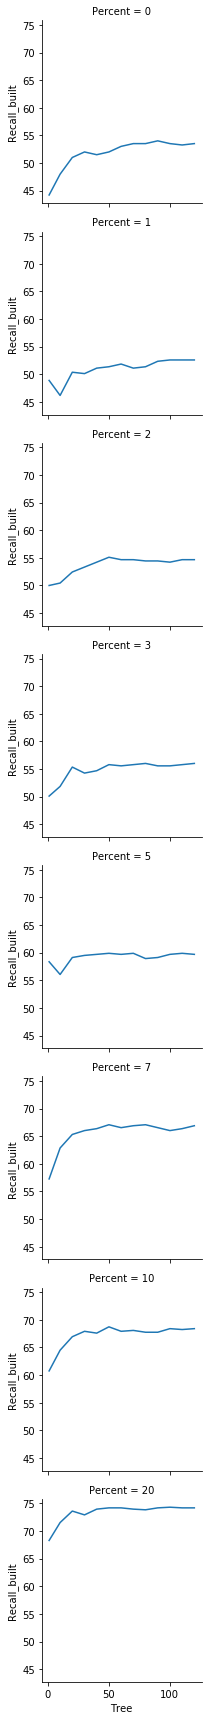

In [23]:
g = sns.FacetGrid(data = Combo_acc_df,row= 'Percent',hue = 'Combo')
g.map(sns.lineplot,'Tree','Recall_built')